In [1]:
%pylab notebook
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt

In [3]:
!ls data/manuvers_raw/

mov1.avi  mov3.pkl  movcalib0_9090.avi	movcalib1_9090.pkl  movcalib3_9090.avi
mov1.pkl  mov4.avi  movcalib0_9090.pkl	movcalib1.avi	    movcalib3_9090.pkl
mov2.avi  mov4.pkl  movcalib0.avi	movcalib1.pkl
mov2.pkl  mov9.avi  movcalib0.pkl	movcalib2.avi
mov3.avi  mov9.pkl  movcalib1_9090.avi	movcalib2.pkl


In [4]:
import pickle
def read_data(fname):
    fd=open(fname,'rb')
    data=[]
    while 1:
        try:
            data.append(pickle.load(fd))
        except EOFError:
            break
    return data

In [5]:
data_calib=read_data('data/manuvers_raw/movcalib2.pkl')
data_test=read_data('data/manuvers_raw/movcalib3_9090.pkl')

In [6]:
data_test[600:603]

[{'a/g': array([ 17116.,    472.,  -1280.,   -190.,    241.,    306.]),
  'alt': 69.91831970214844,
  'mag': array([ 673., -269.,  -63.]),
  's_sync': 17.0691339969635,
  't_stemp_ms': 214.873},
 {'c_sync': 17.069297790527344},
 {'a/g': array([  1.68600000e+04,   7.84000000e+02,  -1.26400000e+03,
          -1.32000000e+02,   2.55000000e+02,   1.00000000e+01]),
  'alt': 69.58306121826172,
  'mag': array([ 673., -270.,  -62.]),
  's_sync': 17.128829956054688,
  't_stemp_ms': 214.933}]

In [7]:
mag_calib=np.array([a['mag'] for a in data_calib if 'mag' in a])
mag_test=np.array([a['mag'] for a in data_test if 'mag' in a])
mag_t=np.array([a['s_sync'] for a in data_test if 'mag' in a])


<IPython.core.display.Javascript object>


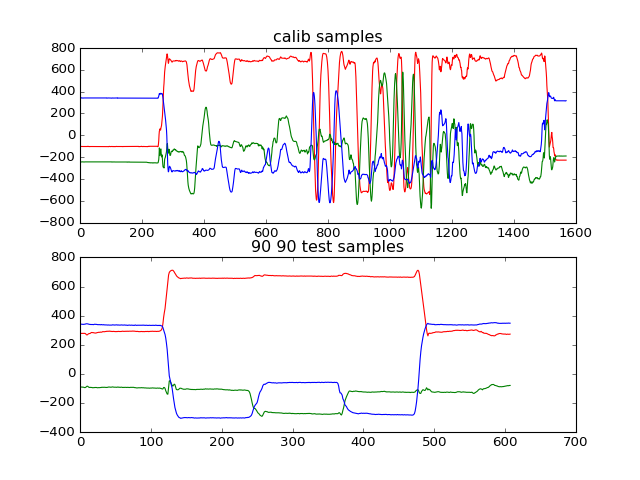

In [8]:
plt.figure()
plt.subplot(2,1,1)
plt.title('calib samples')
plt.plot(mag_calib[:,0],'r')
plt.plot(mag_calib[:,1],'g')
plt.plot(mag_calib[:,2],'b')
plt.subplot(2,1,2)
plt.title('90 90 test samples')
plt.plot(mag_test[:,0],'r')
plt.plot(mag_test[:,1],'g')
plt.plot(mag_test[:,2],'b')


[ 769.  579.  408.] [-617. -669. -619.]


<IPython.core.display.Javascript object>


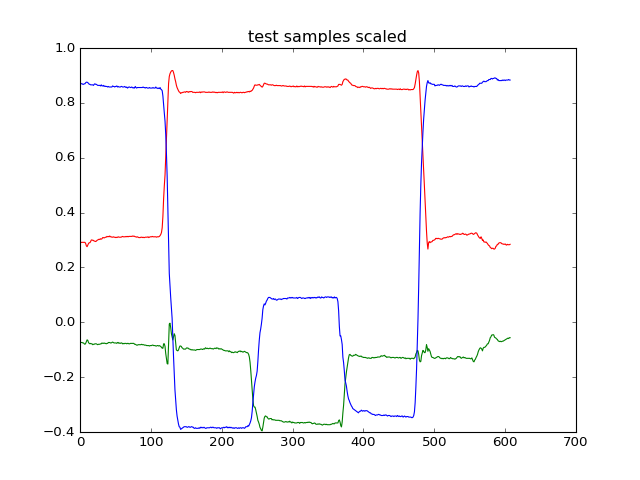

In [9]:
max_calib=mag_calib.max(axis=0)
min_calib=mag_calib.min(axis=0)
print(max_calib,min_calib)
mag_test_calib=mag_test-min_calib
mag_test_calib=2.0*(mag_test_calib/(max_calib-min_calib)-0.5)
plt.figure()
plt.title('test samples scaled')
plt.plot(mag_test_calib[:,0],'r')
plt.plot(mag_test_calib[:,1],'g')
plt.plot(mag_test_calib[:,2],'b')


In [10]:
#plt.figure()
#plt.title('test samples scaled')
reference_frame=220
#plt.plot(mag_test_calib[:,0],'r')
#plt.plot(mag_test_calib[:,1],'g')
#plt.plot(mag_test_calib[:,2],'b')
def norm(X):
    return X/np.sqrt((X**2).sum(axis=0))
mag_test_norm=norm(mag_test_calib.T)
#ref_mag_sample=mag_test_norm[reference_frame]

acc_mat=np.array([a['a/g'][:3] for a in data_test if 'a/g' in a])
acc_norm=norm(acc_mat.T).T
#ref_acc_sample=acc_test_norm[reference_frame]

In [11]:
#print(acc_test_norm[:,0])
accXmax_norm=norm(np.cross(acc_norm,mag_test_norm.T).T).T
accX_accXmax_norm=norm(np.cross(acc_norm,accXmax_norm).T).T
print(np.abs((acc_norm*accXmax_norm).sum(axis=1)).max()) #test perpendicular
print(np.abs((acc_norm*accX_accXmax_norm).sum(axis=1)).max()) #test perpendicular
print(np.abs((accXmax_norm*accX_accXmax_norm).sum(axis=1)).max()) #test perpendicular

5.55111512313e-17
5.55111512313e-17
1.11022302463e-16


In [12]:
rot_mat_array=np.hstack((acc_norm,accXmax_norm,accX_accXmax_norm)).T.reshape((3,3,-1))
rot_mat_array.T[5]

array([[-0.07008716,  0.19383228, -0.97852789],
       [-0.00651974,  0.98083019,  0.19475531],
       [ 0.99751957,  0.02002959, -0.06747987]])

In [13]:
import cv2
axis_angle=np.hstack([cv2.Rodrigues(R)[0] for R in rot_mat_array.T])
angle_rot=np.sqrt((axis_angle.T**2).sum(axis=1))/np.pi*180

<IPython.core.display.Javascript object>


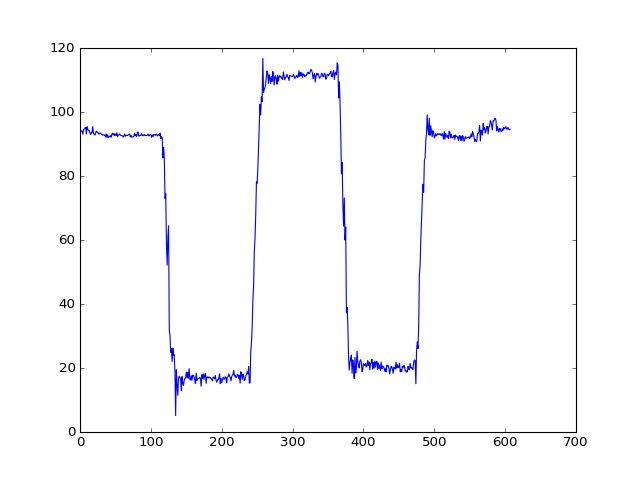

In [14]:
plt.figure()
plot(angle_rot)